In [1]:
####mount the drive if running from Colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# import the necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import cv2
import os
import csv

## Modules to check the performance of the code
from time import process_time 
# !pip install memory_profiler ## When running from Google Colab
# import memory_profiler as mem_profile
# print('Memory (Before): {}Mb'.format(mem_profile.memory_usage()))


## Importing the necessary TesnorFLow modules modules
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name='gpu')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import r2_score ## form calcualting the r2 score
from sklearn.utils import shuffle
from tensorflow import keras as k
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Trasfer Learning Models

from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1 
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB3
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5 
from tensorflow.keras.applications import EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import ResNet50,ResNet50V2
import re


## Checking the availbale number of GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:",gpu.name,"Type:",gpu.device_type)
print("TensorFlow version used ",tf.__version__)

Num GPUs Available:  1
Name: /physical_device:GPU:0 Type: GPU
TensorFlow version used  2.9.2


In [3]:
############ Please provide the same path to the code directory if using Colab################

Path_gdrive= '/content/drive/MyDrive/ISU_Regresion/DPNNet-RT/' ## Comment out this line if using local computer

## Importing the Modules from Modules_DPNNet
import sys
try: ## tries to find the modules in the local directory first
  current_directory = os.getcwd()
  path = current_directory + '/' # For local computer 
#   path = '' # For local computer  
  sys.path.append(path+'MODULES_DPNNeT')
  import data_processing_RT as dp
  import deep_models as dm
  import other_cnns as ocn

########### Folders to save the processed data, files and figures when using Local computer ##############
  output_folder_list = ['data_folder','figures','saved_model']
  for file in output_folder_list:
    try:
        os.makedirs(file)
    except OSError:
        print ("Creation of the directory %s failed/ not needed as it already exit" % file)
    else:
        print ("Successfully created the directory %s" % file)
  
except ModuleNotFoundError:
  
  # #For Colab use:
  # #Point to the path containing the modules in the above section
  #(data folder are a directory above the directory containing the notebook)
  try:
    path = Path_gdrive
    print(path)
    sys.path.append(path+'MODULES_DPNNeT')
    import data_processing_RT as dp
    import deep_models as dm
    import other_cnns as ocn

    ########### Folders to save the processed data, files and figures when using GDRIVE ##############
    import os
    os.chdir(path)
    print("Creating the folders")
    !mkdir -p data_folder
    !mkdir -p figures ## to save the figures
    !mkdir -p figures_paper
    !mkdir -p saved_model
  except ModuleNotFoundError:
    print("The path to the modules is incorrect-- Provide current path")

print("[INFO] Modules imported")

/content/drive/MyDrive/ISU_Regresion/DPNNet-RT/
We are currently using the Modules_DPCNet-RT
Creating the folders
[INFO] Modules imported


In [4]:
## Taking a look at the paramter file 
parameter_df = dp.load_parameter_csv(path)
parameter_df

,Planet_Mass1,Planet_Mass2,Planet_Mass3,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Flaring_Index,Rp1,Rp2,Rp3
0,0.002110,0.00237,0.001880,0.1,0.03000,0.160000,0.0475,1.0,0.0,1.050,2.16,3.03
1,0.001850,0.00195,0.002710,0.1,0.00050,0.030000,0.0389,1.0,0.0,1.160,2.00,2.99
2,0.001340,0.00296,0.002790,0.1,0.00999,0.160000,0.0518,1.0,0.0,0.874,1.83,2.98
3,0.000492,0.00129,0.002130,0.1,0.00999,0.160000,0.0668,1.0,0.0,1.110,2.05,3.13
4,0.002360,0.00162,0.000963,0.1,0.00999,0.000157,0.0754,1.0,0.0,0.954,1.82,2.96
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.001120,0.00000,0.000000,0.1,0.03000,0.160000,0.0675,1.0,0.0,1.030,1.84,3.32
96,0.000322,0.00000,0.000000,0.1,0.00050,0.160000,0.0425,1.0,0.0,1.160,2.11,3.04
97,0.002500,0.00000,0.000000,0.1,0.00999,0.000157,0.0375,1.0,0.0,0.867,1.89,3.24
98,0.001310,0.00000,0.000000,0.1,0.00999,0.030000,0.0925,1.0,0.0,1.080,2.03,3.28


In [5]:
#### Desired Image resoltuion  and Batch Size #####
X_res = Y_res = 128


num_sims = 100
axisymmetric = True
num_ims_per_sim = 150

## Select the kind of Traning ## Both can be selected as well
REG = False #True  ## When choosing regression
CLA = True #False #False #True  ## When Choosing Clasiffication


## Select the Network type

# NETWORK = "Vanilla" ## Cannot be uses at the moment
# NETWORK = "ALEXNET"
# NETWORK = "VGG"
# NETWORK = "RESNET50"

                                ########## When using Trasnfer Learning ######################
NETWORK = "TL"
transfer_model= ResNet50
# transfer_model=EfficientNetB3

## Hyper-Parameter to define
batch_size = 32 ## 20 was for regression ## the best was for 200 last run
valid_batch_size = 100
epochs=10 ## best was 100
init_lr = 1e-5 # 1e-5 (works for regression)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [6]:
############# Address to the data folder ###################

# ## updating the image paths once the transfer is done
list_RT_path = glob.glob(path+ 'image_directory/'+ 'RT_A*') ## make a list of all the RT folder where each folder is for each sim

## When using the local M1
# list_sorted_RT_path  = sorted(list_RT_path, key=lambda x: int(x.split('/')[1].split('_')[2])) ## sorting the images


# ## For google colab this needs to be updated
list_sorted_RT_path  = sorted(list_RT_path, key=lambda f: [int(n) for n in re.findall(r"\d+", f)][-1]) ## sorting the images

############## Will be removed once all the images are ready and tested ####
# print(list_sorted_RT_path)
# df_images_folder_complete=[]
# for index in range(len(list_sorted_RT_path)):

#     path_image = list_sorted_RT_path[index] ## path to each RT folder

#     ## for paths from the RT sim fodlers directly
#     list_image_path = glob.glob(path_image + "/images/snu/"+ "image_"+"*.png") ## list of the path to each image in the RT folder
#     if len(list_image_path) ==0 :## for updates image paths
#         # print("Reading images from the updated folder")
#         list_image_path = glob.glob(path_image+'/'+"*.png") ## list of the path to each image in the RT folder
#         print("index ={}, numberofimges ={}".format(index,len(list_image_path)))
#     df_images_folder =pd.DataFrame(list_image_path,columns=["image_path"])
#     df_images_folder_complete.append(df_images_folder)
    
    
# df_images_folder_complete = pd.concat(df_images_folder_complete, ignore_index=True, axis=0)
# df_images_folder_complete
# The idea is to generate a dataframe with the parameters and the path to the images




data_complete = dp.create_complete_data_csv(list_sorted_RT_path,path)
# data_complete
## Removing the nan if any
data_complete.isna().sum()  # summing the number of na
data_complete= data_complete.dropna()
data_complete

# data_complete['Planet_Count'] = (data_complete.loc[:, ['Planet_Mass1', 'Planet_Mass2', 'Planet_Mass3']] != 0).sum(axis=1)
data_complete = shuffle(data_complete,random_state=42)
dc_list = []

for  i in range(1, num_sims+1):
  if axisymmetric == True:
    dc_list.append(data_complete.loc[data_complete['image_path'].str.contains('RT_A_' + str(i))][:num_ims_per_sim])
  else:
    dc_list.append(data_complete.loc[data_complete['image_path'].str.contains('RT_NA_' + str(i))][:num_ims_per_sim])

data_complete = pd.concat(dc_list)
data_complete = shuffle(data_complete,random_state=49)
data_complete

[INFO]: Importing path for all the RT images
[INFO]: Contatinating the paths of all the RT images is now complete


,Planet_Mass1,Planet_Mass2,Planet_Mass3,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Flaring_Index,Rp1,Rp2,Rp3,image_path
9998,463.333333,60.000000,240.000000,0.1,0.00050,0.03,0.0655,1.0,0.0,1.080,2.16,3.30,/content/drive/MyDrive/ISU_Regresion/DPNNet-RT...
2636,79.000000,177.333333,265.666667,0.1,0.00999,0.16,0.0539,1.0,0.0,1.030,2.09,3.22,/content/drive/MyDrive/ISU_Regresion/DPNNet-RT...
5069,476.666667,623.333333,238.000000,0.1,0.00050,0.03,0.0818,1.0,0.0,1.000,1.87,3.10,/content/drive/MyDrive/ISU_Regresion/DPNNet-RT...
14861,436.666667,0.000000,0.000000,0.1,0.00999,0.03,0.0925,1.0,0.0,1.080,2.03,3.28,/content/drive/MyDrive/ISU_Regresion/DPNNet-RT...
12684,346.666667,0.000000,1000.000000,0.1,0.00999,0.16,0.0685,1.0,0.0,0.824,2.18,2.91,/content/drive/MyDrive/ISU_Regresion/DPNNet-RT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7863,423.333333,60.000000,786.666667,0.1,0.00999,0.03,0.0715,1.0,0.0,0.888,1.90,3.42,/content/drive/MyDrive/ISU_Regresion/DPNNet-RT...
3262,22.166667,400.000000,486.666667,0.1,0.00999,0.03,0.0432,1.0,0.0,0.886,1.95,3.47,/content/drive/MyDrive/ISU_Regresion/DPNNet-RT...
12635,346.666667,0.000000,1000.000000,0.1,0.00999,0.16,0.0685,1.0,0.0,0.824,2.18,2.91,/content/drive/MyDrive/ISU_Regresion/DPNNet-RT...
5793,107.333333,60.000000,670.000000,0.1,0.00999,0.03,0.0565,1.0,0.0,0.952,2.06,3.27,/content/drive/MyDrive/ISU_Regresion/DPNNet-RT...


In [7]:
## partition the data csv file into training and testing splits using 85% of
## the data for training and the remaining 15% for testing
split = train_test_split(data_complete, test_size=0.15, random_state=42)
(train, test) = split

## Save the train and the test data for future use as well.
test.to_csv(path+'data_folder/test_dataset.csv')
train.to_csv(path+'data_folder/train_dataset.csv')

## Generate the Normalized data
normed_train_data, normed_test_data, train_labels, test_labels = dp.process_the_disk_attributes(train, test, path,multi_label=True)

[INFO] preparing the normalized data training/testing split...
Droping the irrelevant columns 
INFO: considering multiple planets as output
[INFO] Done...


In [19]:
import time
start = time.time()

if CLA == True:
        ### Preparing the dataset for the classification problem--- 
        ## For classification we included binary 1 or 0 depending on if the planet is present or not respectively
        train['Planet_Mass2'] = np.where(train['Planet_Mass2']!= 0, 1,0)
        train['Planet_Mass3'] = np.where(train['Planet_Mass3']!= 0, 1,0)
        # train = train.select_dtypes("string")
        test['Planet_Mass2'] = np.where(test['Planet_Mass2']!= 0, 1, 0)
        test['Planet_Mass3'] = np.where(test['Planet_Mass3']!= 0, 1, 0)
        
        Y_train=train[['Planet_Mass2','Planet_Mass3']] ## These are used as label for the non-generator training
        Y_test=test[['Planet_Mass2','Planet_Mass3']]

        y_col=['Planet_Mass2','Planet_Mass3']

elif REG == True:
        y_col=["Planet_Mass1",'Planet_Mass2','Planet_Mass3']

        
        ###### Generate the training and the test images######
if X_res >= 128:
    
    def custom_augmentation(np_tensor):

        '''
        This function is used to crop the images when those are loaded using the 
        ImageDataGenerator Keras function. This custom augmentation function only
        works for three different res as given below. For other resolutions the 
        image needs to the cropped appropiately.

        '''

        # # # dimensions for cropping the image
        if X_res == 128:
          top,left,bottom,right = 20,25,110,90 
        if X_res == 256:          
          top,left,bottom,right = 40,50,220,180          
        if X_res == 512:
          top,left,bottom,right = 60,90,450,380          
                
        image = np.squeeze(np_tensor) 
        crop_image = image[top:bottom, left:right]
        crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
        crop_image = k.preprocessing.image.img_to_array(crop_image)
        return crop_image

    # datagen= ImageDataGenerator(preprocessing_function=custom_augmentation,samplewise_center=True, samplewise_std_normalization=True,rescale=1./255.,validation_split=0.15)
    # datagen= ImageDataGenerator(preprocessing_function=custom_augmentation,featurewise_center=True,featurewise_std_normalization=True,rescale=1./255.,validation_split=0.15)
    datagen= ImageDataGenerator(preprocessing_function=custom_augmentation,rescale=1./255.,validation_split=0.15)

    #### TRAINING GENERATOR #####
    train_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,
    x_col="image_path",
    y_col=y_col,
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(X_res,Y_res))

    #### VALIDATION GENERATOR #####
    validation_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,
    x_col="image_path",
    y_col=y_col,
    subset="validation",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(X_res,Y_res))

    #### TESTING GENERATOR #####
    test_datagen= k.preprocessing.image.ImageDataGenerator(preprocessing_function=custom_augmentation,rescale=1./255.)
    test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=None,
    x_col="image_path",
    y_col=y_col,
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(X_res,Y_res))
    
    
    ## STEP SIZES later used for training using generators
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

 

else:
    print("Uploading directly to RAM as the image resoltuion is manageble")
    trainImagesX = dp.load_disk_images(train, X_res, Y_res, Type = "Train")
    testImagesX = dp.load_disk_images(test, X_res, Y_res, Type = "Test")

Validation_split = 0.15 # 15 percent of the training data is used for validation
print('There are {} Train, {} Validation and {} Test images'.format(int((1-Validation_split)*len(normed_train_data)),int(Validation_split*len(normed_train_data)),len(normed_test_data)))## check the numbers in each category
end = time.time()
print("Total time elapsed =", end - start)

# Getting all memory using os.popen()
total_memory, used_memory, free_memory = map(
    int, os.popen('free -t -m').readlines()[-1].split()[1:])
 
# Memory usage
print("RAM memory % used:", round((used_memory/total_memory) * 100, 2))

Found 10838 validated image filenames.
Found 1912 validated image filenames.
Found 2250 validated image filenames.
There are 10837 Train, 1912 Validation and 2250 Test images
Total time elapsed = 5.6145265102386475
RAM memory % used: 12.16


(32, 128, 128, 3)


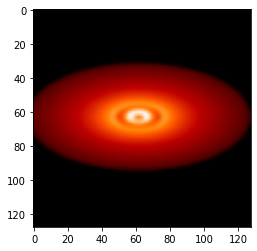

(32, 128, 128, 3)


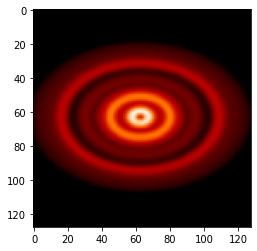

(32, 128, 128, 3)


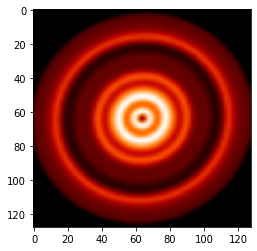

(32, 128, 128, 3)


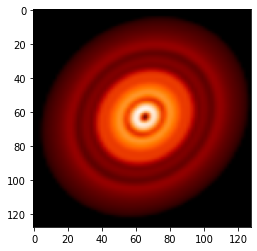

(32, 128, 128, 3)


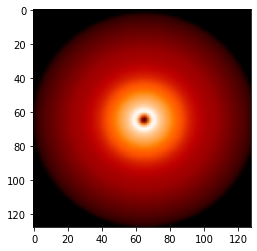

'/content/drive/MyDrive/ISU_Regresion/DPNNet-RT/image_directory/RT_A_73/image_9.png'

In [20]:
for _ in range(5):
     img, label = train_generator.next()
     print(img.shape)   #  (1,256,256,3)
     plt.imshow(img[0])
     plt.show()

filenames =train_generator.filenames
filenames[1]
# # train_labels
# # test
# # normed_test_data

transfer learning

In [21]:
!pip install keras-tuner
import kerastuner as kt
from kerastuner import HyperModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 26.8 MB/s 
     |████████████████████████████████| 1.6 MB 37.4 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

class TRANSFERLEARNINGHYPERMODEL(HyperModel):
    
    def __init__(self,width,height,depth,classes=None,regress=False,multi_label=False,classification=False,option=None,transfer_model= None):
          self.width = width
          self.height = height
          self.depth = depth
          self.classes = classes
          self.regress = regress
          self.multi_label = multi_label
          self.classification = classification
          self.option = option
          self.transfer_model = transfer_model
          print(self.transfer_model)
    
    def build(self, hp):

          '''
          This function introduces the use of Transfer learning to train the DPNNet Model
          Here we use the pretrained weights from the Imagenet data set
          
          Please note this here update the final layers to perform regress or classification
          or both regression and classification together
          
          Input:  1. Dimension of the image [width,height,depth]
                  2. Number of classsification classes if used for calssification
                  3. Regress on or off
                  4. Multilabel -- True for multi-label regression Default == False
                  5. Classification -- True or False 
                  6. Option is the argument to use either softmax (default) or sigmoid for classification
                  7. Select the transfer Learning Model from Either 3 RESNET50 or Efficientnet0-7 models
                  
                  
          Output : Model Build 
          
          '''
          
          ## Input layers
          X_input = layers.Input(shape=(self.height, self.width, self.depth))
          x = X_input
          
          if self.transfer_model == None:
              self.transfer_model = EfficientNetB6
              print("Please Select the Network that will be used-- By Default {} will be used".format(str.lower(self.transfer_model.__name__)))
          
          #### Selecting the model along with the pretrained weights
          mod_name = self.transfer_model.__name__
          print("INFO: Keras Model used is {}".format(mod_name))
          print("Loading weights for {} since this notebook is not connected to internet".format(str.lower(mod_name)))
          
          try:
              model = self.transfer_model(include_top=False,input_tensor=x, weights='imagenet')
          except ValueError:
              model = self.transfer_model(include_top=False,input_tensor=x, weights='imagenet')
        
          
          # Freeze the pretrained weights
          model.trainable = True

          # Rebuild top

          x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
          x = layers.BatchNormalization()(x)

          top_dropout_rate = 0.2
          x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

          XX = Flatten()(x)
          XX = Dense(100, kernel_initializer='he_uniform', activation='relu')(XX) 
          # outputs = layers.Dense(classes, activation="softmax", name="pred")(x)


          if self.classification==True:
            # print("A new fully Connexted layer is added")
            ## Adding a Fully connected layer for classification
            Xclas = XX
            # Xclas = BatchNormalization(axis=1)(Xclas)   
            # top_dropout_rate = 0.30
            # # Xclas = layers.Dropout(top_dropout_rate, name="top_dropout1")(Xclas)  
            # Xclas = Dense(50, kernel_initializer='he_uniform', activation='relu')(Xclas)
            # Xclas = BatchNormalization(axis=1)(Xclas)
            # # top_dropout_rate = 0.20
            # # Xclas = layers.Dropout(top_dropout_rate, name="top_dropout2")(Xclas)

            

            for i in range(hp.Int('num_of_layers',min_value=1,max_value=8,step=1)):         
              #providing range for number of neurons in hidden layers
              Xclas = Dense(units=hp.Int('num_of_neurons_'+ str(i),min_value=10,max_value=40,step=5), kernel_initializer='he_uniform', activation='relu')(Xclas)
          

            Xclas = BatchNormalization(axis=1)(Xclas)

            Xclas = Dropout(hp.Float('dropout_rate',min_value=0, max_value=0.4, step=0.05), name="classification_dropout")(Xclas)

            Xclas = Dense(units=hp.Int('num_of_neurons',min_value=10,max_value=40,step=5), activation='relu')(Xclas)

            if hp.Choice('activation', ['softmax', 'sigmoid']) == 'softmax':
              Xclas = Dense(units=self.classes, activation='softmax', name='clas')(Xclas)
            else:
              Xclas = Dense(units=self.classes, activation='sigmoid', name='clas')(Xclas)

            out_clas = Xclas 


          if self.regress == True:
            print("INFO:CNN is used for regression")
            if self.multi_label==False:           
              Xreg = Dense(1, activation='linear', name='reg', kernel_initializer = glorot_uniform(seed=0))(XX)
            if self.multi_label==True: 
              ## 28 Feb 2022 added the multi-label output 
              print("INFO: Note Multiple Labels are optimised during regression")
              Xreg = Dense(3, activation='linear', name='reg', kernel_initializer = glorot_uniform(seed=0))(XX)
            
            out_reg = Xreg
          

          ### Create model

          optimizer = tf.keras.optimizers.Adam(init_lr, decay=init_lr/epochs)

          if self.classification == True and self.regress == True:
            print("INFO: Performing both regression and classification -- Model Training")
            modelNEWCNN = Model(inputs = X_input,outputs=[out_reg, out_clas])
            modelNEWCNN.compile(loss=['mean_squared_error','binary_crossentropy'],optimizer=optimizer,metrics=['mean_squared_error', 'accuracy'])
          elif self.regress == False:
            X = out_clas
            print("INFO: Classification Model is being trained")
            modelNEWCNN = Model(inputs = X_input, outputs = X)
            modelNEWCNN.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
          elif self.classification is False:
            X = out_reg
            print("INFO: Regression Model is being trained")
            modelNEWCNN = Model(inputs = X_input, outputs = X)
            modelNEWCNN.compile(loss='mean_squared_error',
                    optimizer=optimizer,
                    metrics=['mean_absolute_error', 'mean_squared_error'])

          return modelNEWCNN

In [23]:
print('INFO: Currently training using the {} NETWORK with regression = {} and classification = {}'.format(NETWORK,REG,CLA))
if NETWORK == "Vanilla":
    CNN = dm.build_cnn(X_res, Y_res, 3, regress=True)
elif NETWORK == "ALEXNET":
    CNN = alexnet(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None)
elif NETWORK == "VGG":
    CNN = cnn_vgg(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None)
elif NETWORK == "RESNET50":
    # CNN = Resnet50(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None)
    CNN = ocn.Resnet50(X_res, Y_res, 3,classes=3,regress = REG,multi_label=True,classification=CLA,option=None)
elif NETWORK == "TL":    
    hypermodel = TRANSFERLEARNINGHYPERMODEL(X_res, Y_res, 3,classes=2,regress = REG,multi_label=True,classification=CLA,option=None,transfer_model=transfer_model)
    tuner_bo = kt.BayesianOptimization(
            hypermodel,
            objective=kt.Objective('loss', direction="min"),
            max_trials=5,
            seed=42,
            beta = 4.0,
            executions_per_trial=5
        )
    tuner_bo.search(train_generator,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data=validation_generator,
                            validation_steps=STEP_SIZE_VALID,
                            epochs=epochs)
    CNN = tuner_bo.get_best_models(num_models=1)[0]

if REG == True and CLA ==False:
    
    if X_res >= 128:
        print("INFO: REGRESSION using GENERATORS")       
        CNN_history = CNN.fit_generator(generator=train_generator,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data=validation_generator,
                            validation_steps=STEP_SIZE_VALID,
                            epochs=epochs)
    else:

        CNN_history = CNN.fit(x=trainImagesX, y=train_labels,
                          validation_split = 0.15,epochs=epochs*10, batch_size=batch_size,callbacks=[early_stop])

if REG == False and CLA ==True:
    
    if X_res >= 128:          
        print("INFO: CLASSIFICATION using GENERATORS")  
        CNN_history = CNN.fit_generator(generator=train_generator,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data=validation_generator,
                            validation_steps=STEP_SIZE_VALID,
                            epochs=epochs)
    else: 
        
        CNN_history = CNN.fit(x=trainImagesX, y=Y_train,
                      validation_split = 0.15,epochs=epochs, batch_size=batch_size,callbacks=[early_stop])

if REG == True and CLA ==True:
    # When used for classification and regression

    CNN_history = CNN.fit(x=X_train, y=[train_labels,Y_train],
                      validation_split = 0.15,epochs=epochs, batch_size=batch_size,callbacks=[early_stop])
# Getting all memory using os.popen()


total_memory, used_memory, free_memory = map(
int, os.popen('free -t -m').readlines()[-1].split()[1:])

# Memory usage
print("RAM memory % used:", round((used_memory/total_memory) * 100, 2))
# print('Memory (After Training): {}Mb'.format(mem_profile.memory_usage()))

INFO: Currently training using the TL NETWORK with regression = False and classification = True
<function ResNet50 at 0x7f5e44440710>
INFO: Keras Model used is ResNet50
Loading weights for resnet50 since this notebook is not connected to internet
94765736/94765736 [==============================] - 7s 0us/step
INFO: Classification Model is being trained

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
1                 |3                 |num_of_layers
40                |25                |num_of_neurons_0
0                 |0.05              |dropout_rate
40                |25                |num_of_neurons
sigmoid           |softmax           |activation
40                |40                |num_of_neurons_1
40                |30                |num_of_neurons_2
40                |35                |num_of_neurons_3
40                |15                |num_of_neurons_4

INFO: Keras Model used is ResNet50
Loading weights for resnet50 since this notebook

KeyboardInterrupt: ignored

In [ ]:
hist_df = pd.DataFrame(CNN_history.history)  ## converting to dataframe for future usels
## Saving the history and the model
if NETWORK == "TL":
    if REG == True and CLA == True:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelRC')
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelRC'+'_history.csv')
    elif REG == True and CLA == False:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelR')
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelR'+'_history.csv')    
    elif CLA == True and REG == False:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelC')        
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelC'+'_history.csv')
    
else:    

    if REG == True and CLA == True:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelRC')
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str(X_res)+'_modelRC'+'_history.csv')
    elif REG == True and CLA == False:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelR')
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str(X_res)+'_modelR'+'_history.csv')    
    elif CLA == True and REG == False:
        CNN.save(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelC')
        hist_df.to_csv(path+'data_folder/'+NETWORK+'_'+str(X_res)+'_modelC'+'_history.csv')

In [ ]:
# Loading the model

if NETWORK == "TL":
    if REG == True and CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelRC')
    elif REG == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelR')
    elif CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelC')
        
    print("INFO:The Trained model {} at res {} is loaded ".format(NETWORK+'_'+str( transfer_model.__name__),str(X_res)))
else:
    if REG == True and CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelRC')
    elif REG == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelR')
    elif CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelC')

INFO:The Trained model TL_ResNet50 at res 128 is loaded 


In [ ]:
test_index = 41 # 550  #550 ##210
if X_res >= 128:

    test_generator.reset()
    pred_CNN=CNN.predict_generator(test_generator,
    steps=STEP_SIZE_TEST,
    verbose=1)
else:
    
    pred_CNN = CNN.predict(testImagesX)  
pred_CNN[test_index]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


70/70 [==============================] - 586s 8s/step


array([397.47546, 379.7265 , 432.15018], dtype=float32)

In [ ]:
# plt.imshow(testImagesX[test_iclass_mode)
if REG == True:
    print("The predicted Values are {} and \nThe True values are \n{} ".format(pred_CNN[test_index],test_labels.iloc[test_index]))
elif CLA == True:
    print("The predicted prbability of the presence of planets are {} and \nThe True values are \n{} ".format(pred_CNN[test_index],Y_test.iloc[test_index]))
    print("The predicted Values are {} and \nThe True values are \n{} ".format(pred_CNN[test_index],test_labels.iloc[test_index]))
    

The predicted Values are [397.47546 379.7265  432.15018] and 
The True values are 
Planet_Mass1    760.000000
Planet_Mass2    873.333333
Planet_Mass3    182.333333
Name: 5225, dtype: float64 


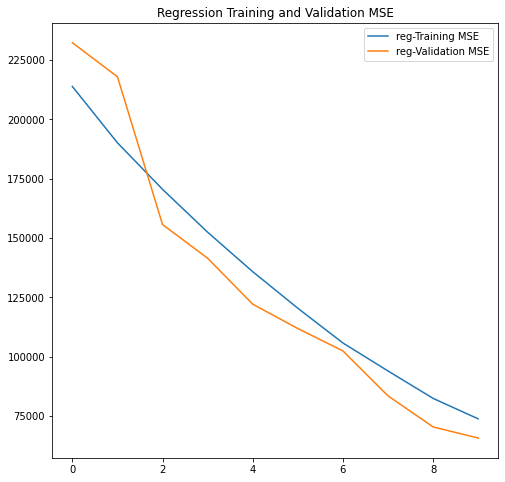

<Figure size 432x288 with 0 Axes>

In [ ]:
###fc_mean_squared_error fc_accuracy dense_3_mean_squared_error dense_3_accuracy
hist =pd.DataFrame(CNN_history.history)
hist['epoch'] = hist.index = hist.index
hist
if NETWORK == "TL":
    plot_name = NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)
else:
    plot_name = NETWORK+'_'+str(X_res)
if  CLA == True and REG== False:
    cla_acc = CNN_history.history['accuracy']
    val_cla_acc = CNN_history.history['val_accuracy']
    cla_loss =CNN_history.history['loss']
    val_cla_loss = CNN_history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    # plt.subplot(2, 2, 1)
    plt.plot(hist['epoch'], cla_acc, label='cla-Training Accuracy')
    plt.plot(hist['epoch'], val_cla_acc, label='cla-Validation Accuracy')
    
    plt.legend(loc='upper right')
    plt.title('Classification Training and Validation Accuracy')
    plt.savefig('figures/'+plot_name+'_c.png')
    plt.show()
    
if REG == True and CLA == False:
    ## For Regression
    reg_mse = CNN_history.history['mean_squared_error']
    val_reg_mse =CNN_history.history['val_mean_squared_error']
    reg_loss =CNN_history.history['loss']
    val_reg_loss = CNN_history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    # plt.subplot(2, 2, 1)
    # plt.ylim(0,50000)
    plt.plot(hist['epoch'], reg_mse, label='reg-Training MSE')
    plt.plot(hist['epoch'], val_reg_mse, label='reg-Validation MSE')
    plt.legend(loc='upper right')
    plt.title('Regression Training and Validation MSE')
    plt.show()
    plt.savefig('figures/'+plot_name+'_r.png')

if REG == True and CLA == True:
    ## For classification
    cla_acc = CNN_history.history['cla_accuracy']
    val_cla_acc = CNN_history.history['val_cla_accuracy']
    cla_loss =CNN_history.history['cla_loss']
    val_cla_loss = CNN_history.history['val_cla_loss']

    ## For Regression
    reg_mse = CNN_history.history['reg_mean_squared_error']
    val_reg_mse =CNN_history.history['val_reg_mean_squared_error']
    reg_loss =CNN_history.history['reg_loss']
    val_reg_loss = CNN_history.history['val_reg_loss']
    
    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(hist['epoch'], cla_acc, label='cla-Training Accuracy')
    plt.plot(hist['epoch'], val_cla_acc, label='cla-Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Classification Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(hist['epoch'], reg_mse, label='reg-Training MSE')
    plt.plot(hist['epoch'], val_reg_mse, label='reg-Validation MSE')
    plt.legend(loc='upper right')
    plt.title('Regression Training and Validation MSE')
    plt.savefig('figures/'+plot_name+'_cr.png')